In [1]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta


In [2]:
df = pd.read_csv("consumption_temp.csv")
df['time'] = pd.to_datetime(df['time'])

df.describe()

,time,consumption,temperature
count,49494,49494.000000,49494.000000
mean,2022-10-11 02:25:46.223784704,3.509242,6.554019
min,2022-04-07 21:00:00,0.000000,-17.299999
25%,2022-07-19 03:00:00,1.263256,1.000000
50%,2022-10-13 01:00:00,2.376530,6.800000
75%,2023-01-06 23:00:00,5.189000,12.100000
max,2023-04-02 21:00:00,18.045011,30.500000
std,NaN,3.096356,7.630308


In [3]:
import pandas as pd
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['month'] = df['time'].dt.month

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

lags = [24, 25, 26, 48, 49, 50, 72, 96, 120, 144, 168]
delay = 120

for lag in lags:
    df[f'load_t-{lag}h'] = df.groupby('location')['consumption'].shift(lag+delay)
    df[f'avg_load_t-{lag}h'] = df['consumption'].shift(lag+delay).expanding().mean()
    df[f'temperature_t-{lag}h'] = df.groupby('location')['temperature'].shift(lag)
    

df.reset_index(inplace=True)

df.dropna(inplace=True)


In [4]:

df['original_location'] = df['location']
df = pd.get_dummies(df, columns=['location'])

In [5]:
target = 'consumption'

df_0_10 = df[df['hour'] < 10].copy()
df_11_24 = df[df['hour'] >= 10].copy()

excluded_features = ['time', 'temperature', 'consumption', 'original_location']
features_0_10 = [col for col in df.columns if col not in excluded_features]
features_11_24 = [col for col in df.columns if col not in excluded_features + ['consumption_t-24h', 'avg_load_t-24h']]


df_0_10.dropna(subset=features_0_10 + [target], inplace=True)
df_11_24.dropna(subset=features_11_24 + [target], inplace=True)

last_date = df['time'].max().date()
test_start_date = last_date - timedelta(days=29)

train_0_10 = df_0_10[df_0_10['time'].dt.date < test_start_date]
test_0_10 = df_0_10[df_0_10['time'].dt.date >= test_start_date]

train_11_24 = df_11_24[df_11_24['time'].dt.date < test_start_date]
test_11_24 = df_11_24[df_11_24['time'].dt.date >= test_start_date]

model_0_10 = RandomForestRegressor(n_estimators=100, random_state=42)
model_0_10.fit(train_0_10[features_0_10], train_0_10[target])

model_11_24 = RandomForestRegressor(n_estimators=100, random_state=42)
model_11_24.fit(train_11_24[features_11_24], train_11_24[target])

pred_0_10 = model_0_10.predict(test_0_10[features_0_10])
mse_0_10 = mean_squared_error(test_0_10[target], pred_0_10)

pred_11_24 = model_11_24.predict(test_11_24[features_11_24])
mse_11_24 = mean_squared_error(test_11_24[target], pred_11_24)

print(f'MSE for 0-10: {mse_0_10}')
print(f'MSE for 11-24: {mse_11_24}')


MSE for 0-10: 0.3453819010362544
MSE for 11-24: 0.23738067023704865


        time original_location  consumption  prediction
0 2023-03-04            bergen     3.044938    2.989187
1 2023-03-04       helsingfors     6.373000    6.366061
2 2023-03-04              oslo    10.704361   11.201179
3 2023-03-04         stavanger     5.085620    5.306201
4 2023-03-04            tromsø     1.954974    1.739481


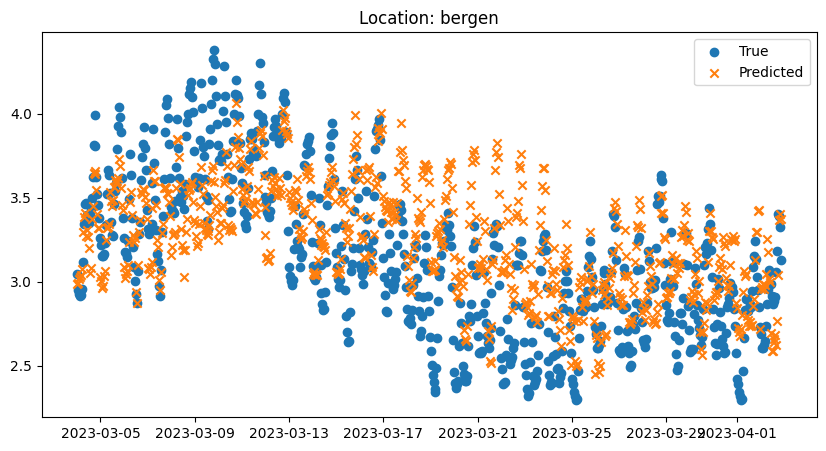

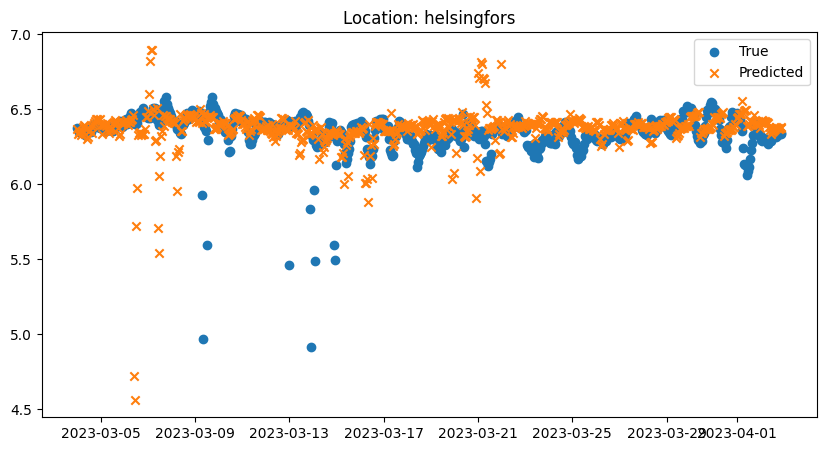

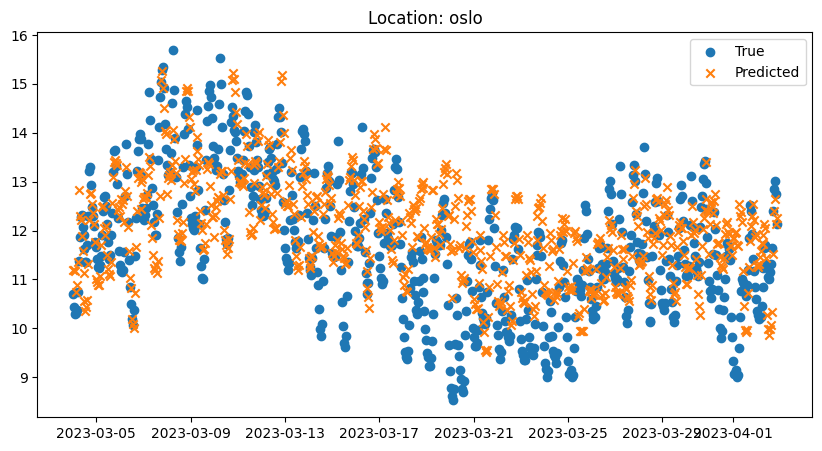

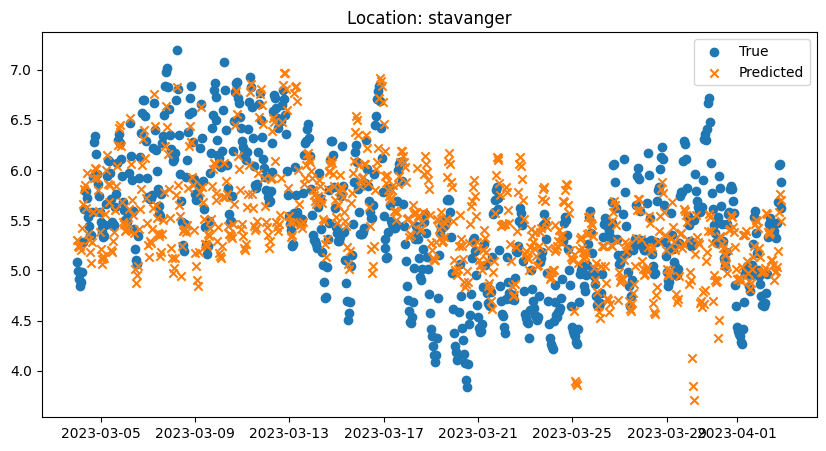

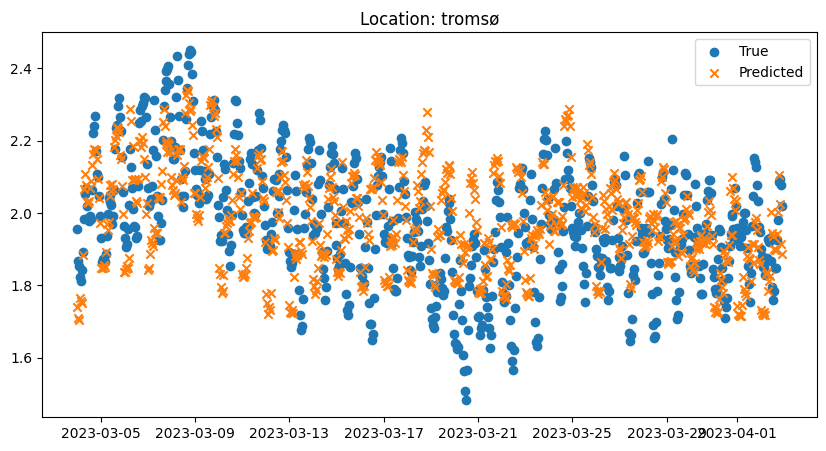

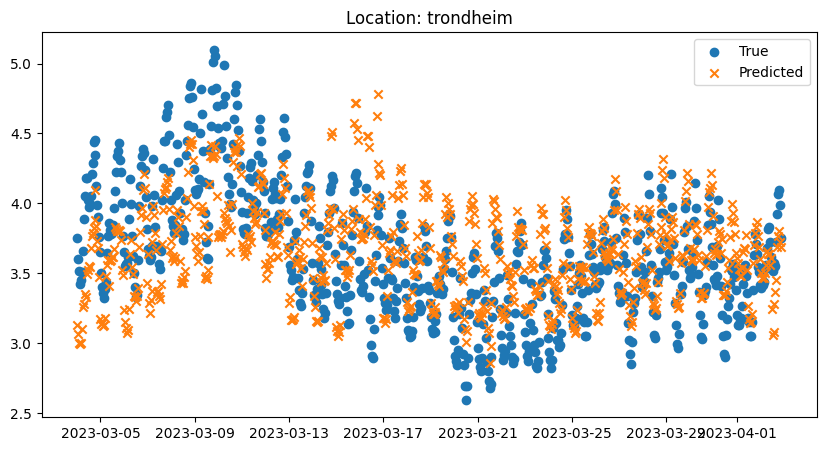

In [6]:


predictions_0_10 = model_0_10.predict(test_0_10[features_0_10])
results_0_10 = test_0_10[['time', 'original_location', target]].copy()
results_0_10['prediction'] = predictions_0_10

predictions_11_24 = model_11_24.predict(test_11_24[features_11_24])
results_11_24 = test_11_24[['time', 'original_location', target]].copy()
results_11_24['prediction'] = predictions_11_24

combined_results = pd.concat([results_0_10, results_11_24])

combined_results = combined_results.sort_values(by='time')

combined_results.reset_index(drop=True, inplace=True)

print(combined_results.head())

import matplotlib.pyplot as plt

locations = combined_results['original_location'].unique()
for location in locations:
    location_data = combined_results[combined_results['original_location'] == location]
    plt.figure(figsize=(10,5))
    plt.scatter(location_data['time'], location_data[target], label='True', marker='o')
    plt.scatter(location_data['time'], location_data['prediction'], label='Predicted', marker='x')
    plt.title(f'Location: {location}')
    plt.legend()
    plt.show()
